In [72]:
from sklearn.feature_extraction.text import HashingVectorizer, ENGLISH_STOP_WORDS, TfidfVectorizer
#from sklearn.feature_extraction import stop_words
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics, cluster
from sklearn.decomposition import PCA #PCA

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
# nltk.download('stopwords')
# nltk.download('wordnet')

import string
import itertools


In [2]:
# Import data

df = pd.read_csv('fake_news_dataset.csv')

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
    df.shape

(20800, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [6]:
# Dropping ID column

df = df.drop(columns=['id'])

In [7]:
# Replacing NULL values with empty string

df = df.fillna('')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20800 non-null  object
 1   author  20800 non-null  object
 2   text    20800 non-null  object
 3   label   20800 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 650.1+ KB


In [9]:
df['label'].value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [10]:
pd.options.mode.chained_assignment = None  
df['corpus'] = df['title'] + ' ' + df['author'] + ' ' + df['text']

In [11]:
df

,title,author,text,label,corpus
0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Consortiumne...
3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...
4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...
...,...,...,...,...,...
20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,Rapper T.I.: Trump a ’Poster Child For White S...
20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,Macy’s Is Said to Receive Takeover Approach by...
20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [12]:
df = df.drop(['title','author','text'], axis=1)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20800 non-null  int64 
 1   corpus  20800 non-null  object
dtypes: int64(1), object(1)
memory usage: 325.1+ KB


In [14]:
df.head(10)

,label,corpus
0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,1,Why the Truth Might Get You Fired Consortiumne...
3,1,15 Civilians Killed In Single US Airstrike Hav...
4,1,Iranian woman jailed for fictional unpublished...
5,0,Jackie Mason: Hollywood Would Love Trump if He...
6,1,Life: Life Of Luxury: Elton John’s 6 Favorite ...
7,0,Benoît Hamon Wins French Socialist Party’s Pre...
8,0,Excerpts From a Draft Script for Donald Trump’...
9,0,"A Back-Channel Plan for Ukraine and Russia, Co..."


In [15]:
# Splitting data to training and test sets

x_train, x_test, y_train, y_test = train_test_split(df.corpus, df.label, test_size=0.20, random_state=0)

In [21]:
x_train.head()

15902    Trump Reopening 9/11, Reversing Rome, in Bid t...
7375     Trump Inherits a Secret Cyberwar Against North...
4889     Sergei Shoigu: Admiral Kuznetsov Aircraft-carr...
2143     With Mass Protests, South Koreans Wield a Fami...
18373    The Most Important Primary Is ... Wait, Indian...
Name: corpus, dtype: object

In [30]:
x_test.head()

20386    Bob Dylan’s Nobel Prize: A Podcast Discussion ...
16794    Nuclear Weapons in South Korea under Discussio...
5500     Solar Storm Alert No Author October 27, 2016 S...
9398     Keith Lamont Scott Was Killed by Two Gunshot W...
4266     Tom Cotton: Paul Ryan’s Healthcare Bill Does N...
Name: corpus, dtype: object

In [31]:
y_train.head()

15902    1
7375     0
4889     1
2143     0
18373    0
Name: label, dtype: int64

In [32]:
y_test.head()

20386    0
16794    1
5500     1
9398     0
4266     0
Name: label, dtype: int64

In [26]:
# word stemmer to reduce words to root forms

stemmer = PorterStemmer()

In [28]:
# Hashing Vectorizer

hashing_vectoriser = HashingVectorizer(stop_words='english', analyzer=stemmer.stem)

hashing_train = hashing_vectoriser.fit_transform(x_train)

hashing_test = hashing_vectoriser.transform(x_test)

In [29]:
# TF-IDF Vectorizer

tfidf_vectoriser = TfidfVectorizer(stop_words='english', analyzer=stemmer.stem)

tfidf_train = tfidf_vectoriser.fit_transform(x_train)

tfidf_test = tfidf_vectoriser.transform(x_test)

In [50]:

tfidf_train

<16640x1032 sparse matrix of type '<class 'numpy.float64'>'
	with 724712 stored elements in Compressed Sparse Row format>

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [41]:
kmeans = KMeans(n_clusters=2, n_init=20)


In [42]:
hashing_clustered = kmeans.fit_predict(hashing_train)
hashing_clustered_results = metrics.accuracy_score(y_train, hashing_clustered)
hashing_clustered_results

0.49044471153846153

In [68]:
pd.DataFrame(hashing_clustered).value_counts()

1    16502
0      138
dtype: int64

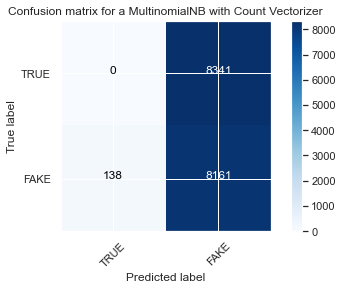

In [73]:
hashing_cm = metrics.confusion_matrix(y_train, hashing_clustered, labels=[0,1])

plot_confusion_matrix(hashing_cm, classes=['TRUE','FAKE'], title ='Confusion matrix for KMeans Clustering with Hashing Vectorizer')

In [43]:
tfidf_clustered = kmeans.fit_predict(tfidf_train)
tfidf_clustered_results = metrics.accuracy_score(y_train, tfidf_clustered)
tfidf_clustered_results

0.5095552884615384

In [69]:
pd.DataFrame(tfidf_clustered).value_counts()


0    16502
1      138
dtype: int64

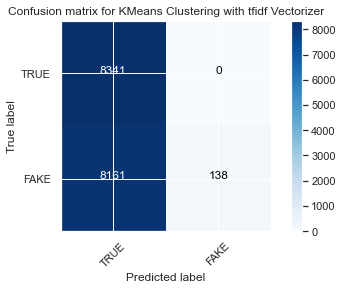

In [74]:
tfidf_cm = metrics.confusion_matrix(y_train, tfidf_clustered, labels=[0,1])

plot_confusion_matrix(tfidf_cm, classes=['TRUE','FAKE'], title ='Confusion matrix for KMeans Clustering with tfidf Vectorizer')

Unsupervised learning was not effective in discriminating real and fake news. There may not exist sufficient inherent patterns in news content to effectively discrimate between real and fake news.